# Comparing different models and data sources in the oos prediction

Predictions from micro data (RF and DNN), as well as satellite data overpredict turnout systematically. 

* Are only the micro data predictions similar? If so, it is a micro data issue.
* Are only the predictions with the neural nets the same? If so, it is a DNN issue.
* Are all overpredicted stations the same ones?
* Are they all different? 

In [1]:
import tensorflow as tf

### Houskeeping

In [2]:
tf.__version__


'2.4.1'

In [3]:

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# import the necessary packages
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop



In [5]:


import glob
import numpy as np
# import csv
from itertools import compress
import rasterio
import random
import json
import math
import time
import os
import sys
import pandas as pd
# Self written functions
from helpers.helpers_read_data import *
# from helpers.helpers_models_tf2 import *
# from helpers.helpers_performance_analytics import *



# 1 Data Work
## Adapting the reading of the satellite images

In [6]:
images_path = '/Users/haui/Desktop/Kenya_Landsat7_1y_before_election_scale30'
# images_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/data/landsat7_temp'
ps_data_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/data/kenya13_vars.json'

image_data, image_ps_id = read_stllt_images_and_names(images_path)

In [7]:
len(image_data)

24599

In [ ]:
imgplot = plt.imshow(img)
# id of the polling station
ps_votes_cast[selector][7]
# in the .xls, the name of the ps is "KAMUJWA PRIMARY SCHOOL". Search for it on googlemaps to compare. 
# It is checking out

In [8]:
# 1 Prepare data dictionaries for easy querying
# Images dict at PS level
images_data_dict = dict(zip(image_ps_id,image_data))

In [127]:
# Let us use the same data as for the DNN
raw_dat = pd.read_csv('../data/final-for-analysis.csv')

dat = pd.concat([raw_dat['psid'],
                 # turnout
                 raw_dat["turnout_count"], raw_dat["registered_voters"], 
                 # ethnic frac (let's simply average...)
                 raw_dat['ethnic_frac'],
                 # other PS level data
                 raw_dat['terrain_elevation'], raw_dat['terrain_ruggedness'],
                   raw_dat['terrain_slope'],raw_dat['poverty_rate'], raw_dat['literacy_rate'],
                   raw_dat['dependency_ratio'],raw_dat['skilled_birth_att'],
                   raw_dat['night_lights'],raw_dat['county_name']], axis=1)


dat_ps = dat.groupby('psid').agg({
    # preparing for turnout
    'turnout_count': 'sum',
    'registered_voters': 'sum',
    # assumption. but fair approx for now, since all streams have (sort of) same weight
    'ethnic_frac': 'mean',
    # Polling Station level anyway
    'terrain_elevation': 'first',
    'terrain_ruggedness': 'first',
    'terrain_slope': 'first',
    'poverty_rate': 'first',
    'literacy_rate': 'first',
    'dependency_ratio': 'first',
    'skilled_birth_att': 'first',
    'night_lights': 'first',
    'county_name': 'first',
})




/Users/haui/anaconda3/envs/tf2_vi/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [128]:
dat_ps.head()
# dat_ps.tail() TODO there is something weird happening

,turnout_count,registered_voters,ethnic_frac,terrain_elevation,terrain_ruggedness,terrain_slope,poverty_rate,literacy_rate,dependency_ratio,skilled_birth_att,night_lights,county_name
psid,,,,,,,,,,,,
001/001,3369.0,5267.0,0.559003,-2.196058,-0.752885,-0.756035,-2.109904,6.377350,-2.322930,0.612534,3.677581,MOMBASA
001/002,2354.0,3489.0,0.662413,-2.205743,-0.794555,-0.788982,-2.179095,6.078287,-2.455718,0.615652,3.662392,MOMBASA
001/003,1295.0,2277.0,0.654413,-2.207539,-0.737618,-0.740169,-2.209238,6.424049,-2.455718,0.614910,3.678592,MOMBASA
001/004,1751.0,2337.0,0.556684,-2.203868,-0.768254,-0.770896,-2.199451,6.468515,-2.455718,0.614704,3.686981,MOMBASA
001/005,1070.0,1448.0,0.500205,-2.203344,-0.669685,-0.670843,-2.201605,6.475418,-2.455718,0.613048,3.692524,MOMBASA


#### Clean data 

In [129]:
# turn rown names from grouping into own column
dat_ps.index.name = 'psid'
dat_ps.reset_index(inplace=True)
# replace the / for a - to be in sync with the image names
dat_ps['psid'] = dat_ps['psid'].str.replace('/','-')

In [130]:
# calculate and correct turnout
dat_ps['registered_voters'] = dat_ps['registered_voters'].replace(0, np.NaN)
dat_ps['turnout'] = dat_ps["turnout_count"]/dat_ps['registered_voters']
dat_ps['turnout'].values[dat_ps['turnout'] > 1] = np.NaN
# drop NaNs
dat_ps = dat_ps.dropna()
# turn into dictionary for polling stations
# ps_data_dict = dict(zip(list(dat_ps['psid']), list(dat_ps['turnout'])))
# 
dat_ps = pd.get_dummies(dat_ps, columns=['county_name'], prefix='', prefix_sep='')



In [131]:
dat_ps.shape


(22008, 60)

In [132]:
# # Data Checks
dat_ps.head()
max(dat_ps['turnout'])
min(dat_ps['turnout'])

0.01824817518248175

#### Make sure each data point is only covered once and that we have data for it
* In the polling station data check for double entries 
* Do we have data for the sat image?


In [133]:
unique_ps_id = list(set(list(dat_ps['psid'])))
# assert each id occurs only once
assert len(unique_ps_id)==dat_ps.shape[0]

ps_id_at_ps_level = list(dat_ps['psid'])
# turnout_at_ps_level = list(dat_ps['turnout'])


## Split up the three data sources -- in the correct order
* ID vars are in: ps_id_at_ps_level_wona
* images are in: images_at_ps_level_wona
* outcome var is in: turnout_at_ps_level_wona
* further EVs are in: dat_ps_features_wona


In [134]:
# This creates a mask to check for which satellite images we actually have data. 
# Returns 
# a) a list with the photos of the polling stations for which there are data 
# b) And a mask that you can use to select later on
images_at_ps_level_wona = []
mask = [True]*len(ps_id_at_ps_level)

In [135]:
# this is a name query in the order of the ps_ids in the dat_ps data set
# in result, the sat images are queried from the images_data_dict dictionary in the same order as dat_ps
for i in range(len(ps_id_at_ps_level)):
    try:
        images_at_ps_level_wona.append(images_data_dict[ps_id_at_ps_level[i]])
    except:
        mask[i] = False

In [136]:
# keeps those data for which we also have a sat image
dat_ps_wona = dat_ps[mask]

In [137]:
print('We do not have data for',len(ps_id_at_ps_level) - len(images_at_ps_level_wona),'sat images. \n')

We do not have data for 6 sat images. 



In [138]:
# this generates the data we need for the model
dat_ps_features_wona = dat_ps_wona.copy()
turnout_at_ps_level_wona = list(dat_ps_features_wona.pop('turnout'))
ps_id_at_ps_level_wona = list(dat_ps_features_wona.pop('psid'))



Now: also kick out the data that would give away the turnout


In [139]:
turnout_count_at_ps_level_wona = list(dat_ps_features_wona.pop('turnout_count'))
registered_voters_at_ps_level_wona = list(dat_ps_features_wona.pop('registered_voters'))


In [140]:
# reduce to the FE features, only
# dat_ps_features_wona = dat_ps_features_wona.drop(columns = ["turnout_count", "registered_voters"])

In [141]:
assert (dat_ps_features_wona.shape[0] == len(ps_id_at_ps_level_wona) == 
        len(images_at_ps_level_wona) == len(turnout_at_ps_level_wona)), 'Something went wrong in the data generation. There are different lengths'

### Splitting the train test set

In [142]:
# defines the new random order
new_order = random.sample(range(len(turnout_at_ps_level_wona)), len(turnout_at_ps_level_wona))

In [143]:
# defines train-test-val size
observed_ps_set_size = len(turnout_at_ps_level_wona)
testval_set_size = math.floor(.1*observed_ps_set_size)
# train_set_size = observed_ps_set_size - 2*testval_set_size
train_set_size = observed_ps_set_size - testval_set_size

In [144]:
# reshape images
image_data_all_bands = np.stack(images_at_ps_level_wona, axis = 0)

In [145]:
image_data_all_bands = image_data_all_bands.reshape((observed_ps_set_size, 96, 96, 7))

#### train val test sat images

In [146]:
train_images = image_data_all_bands[new_order[0:train_set_size],:,:,:].reshape(train_set_size, 96, 96, 7)
# val_images = image_data_all_bands[new_order[train_set_size:(train_set_size+testval_set_size)],:,:,:].reshape((testval_set_size, 96, 96, 7))
# test_images = image_data_all_bands[new_order[(train_set_size+testval_set_size):observed_ps_set_size],:,:,:].reshape((testval_set_size, 96, 96, 7))
test_images = image_data_all_bands[new_order[train_set_size:observed_ps_set_size],:,:,:].reshape((testval_set_size, 96, 96, 7))

#### train val test ps data

In [147]:
train_ps_data = np.array(dat_ps_features_wona)[new_order[0:train_set_size],:]
# val_ps_data = np.array(dat_ps_wona_features)[new_order[train_set_size:(train_set_size+testval_set_size)],:]
# test_ps_data = np.array(dat_ps_wona_features)[new_order[(train_set_size+testval_set_size):observed_ps_set_size],:]
test_ps_data = np.array(dat_ps_features_wona)[new_order[train_set_size:observed_ps_set_size],:]

In [148]:
# normalise the data
normalizer = Normalization()
normalizer.adapt(np.array(train_ps_data))

In [149]:
train_ps_data_normalized =normalizer(train_ps_data)
test_ps_data_normalized =normalizer(test_ps_data)


#### train val test labels

In [150]:
train_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[0:train_set_size]])
# val_labels = [turnout_at_ps_level_wona[i] for i in new_order[train_set_size:(train_set_size+testval_set_size)]]
test_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[train_set_size:observed_ps_set_size]])

In [151]:
# save the ids
# e.g. to write the train_val_test split as json for eventual later use
train_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[0:train_set_size]]
# val_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[train_set_size:(train_set_size+testval_set_size)]]
test_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[train_set_size:observed_ps_set_size]]

# 2 Training Models
## 2.1 CNN Sat Images

In [36]:

def model2():
    '''Insight: Going deeper than 5 layers here stops the learning '''
    # new model
    network = Sequential()
    #--- Convolutional Layers
    # Convolutional Layer
    network.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 7)))
    network.add(BatchNormalization())
    network.add(MaxPooling2D((2, 2)))
    # Convolutional Layer
    network.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    network.add(BatchNormalization())
    network.add(MaxPooling2D((2, 2)))
    # Convolutional Layer
    network.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    network.add(BatchNormalization())
    network.add(MaxPooling2D((2, 2)))
    # Convolutional Layer
    network.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    network.add(BatchNormalization())
    network.add(MaxPooling2D((2, 2)))
    # Convolutional Layer
    network.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    network.add(BatchNormalization())
    network.add(MaxPooling2D((2, 2)))
    #--- Dense Layers
    # Dense Layer
    network.add(Dropout(.3))
    network.add(Flatten())
    network.add(Dense(512, activation='relu'))
    # Dense Layer
    network.add(Dropout(.4))
    network.add(Dense(128, activation='relu'))
    # Dense 3
    network.add(Dense(1, activation='sigmoid'))
    return(network)


In [37]:
network = model2()

In [38]:
optimizer = RMSprop()

In [39]:
network.compile(optimizer=optimizer,
                    loss='mse',
                    metrics=['mae'])


In [50]:
best_model_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_CNN_images.h5'
# select best models, but with early stopping
early_stopper = EarlyStopping(monitor='val_mae', patience=15,
    mode='min', min_delta=0.0001)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_mae', verbose=1,
    save_best_only=True, mode='min')
callbacks_list = [early_stopper, checkpoint]


In [51]:

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Train

In [52]:

# do the work
history = network.fit(train_images, train_labels,
            epochs=100 , batch_size=16, callbacks=callbacks_list,
            validation_split=0.1)


Epoch 1/100
1152/1152 [==============================] - 163s 140ms/step - loss: 0.0301 - mae: 0.1349 - val_loss: 0.0266 - val_mae: 0.1331

Epoch 00001: val_mae improved from inf to 0.13312, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_CNN_images.h5
Epoch 2/100
1152/1152 [==============================] - 165s 143ms/step - loss: 0.0272 - mae: 0.1325 - val_loss: 0.0248 - val_mae: 0.1311

Epoch 00002: val_mae improved from 0.13312 to 0.13114, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_CNN_images.h5
Epoch 3/100
1152/1152 [==============================] - 166s 144ms/step - loss: 0.0235 - mae: 0.1183 - val_loss: 0.0107 - val_mae: 0.0757

Epoch 00003: val_mae improved from 0.13114 to 0.07574, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_mode

1152/1152 [==============================] - 172s 149ms/step - loss: 0.0055 - mae: 0.0491 - val_loss: 0.0088 - val_mae: 0.0627

Epoch 00037: val_mae did not improve from 0.05272
Epoch 38/100
1152/1152 [==============================] - 165s 144ms/step - loss: 0.0054 - mae: 0.0481 - val_loss: 0.0072 - val_mae: 0.0608

Epoch 00038: val_mae did not improve from 0.05272
Epoch 39/100
1152/1152 [==============================] - 167s 145ms/step - loss: 0.0052 - mae: 0.0478 - val_loss: 0.0096 - val_mae: 0.0725

Epoch 00039: val_mae did not improve from 0.05272
Epoch 40/100
1152/1152 [==============================] - 166s 144ms/step - loss: 0.0051 - mae: 0.0480 - val_loss: 0.0085 - val_mae: 0.0709

Epoch 00040: val_mae did not improve from 0.05272
Epoch 41/100
1152/1152 [==============================] - 166s 144ms/step - loss: 0.0050 - mae: 0.0477 - val_loss: 0.0086 - val_mae: 0.0615

Epoch 00041: val_mae did not improve from 0.05272


In [58]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, .05])
  plt.xlabel('Epoch')
  plt.ylabel('Error [percentage]')
  plt.legend()
  plt.grid(True)


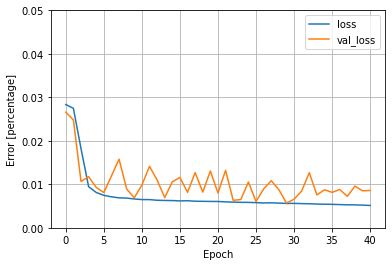

In [59]:
plot_loss(history)

In [60]:
network.load_weights(best_model_path)


In [61]:

network.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae'])



In [233]:
predictions_images = network.predict(test_images).flatten()

In [234]:
predictions_images

array([0.8929356 , 0.85794246, 0.8995224 , ..., 0.9264778 , 0.83635473,
       0.9238906 ], dtype=float32)

In [235]:
results = network.evaluate(test_images, test_labels)

69/69 [==============================] - 5s 66ms/step - loss: 0.0061 - mae: 0.0528


In [236]:
print("test loss, test MAE:", results)


test loss, test MAE: [0.006120300851762295, 0.05279027670621872]


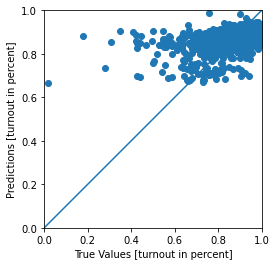

In [237]:
# test_predictions = network.predict(test_images)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions_images)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## 2.2 DNN Micro Data 

In [152]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_ps_data))

train_ps_data_normalized =normalizer(train_ps_data)
test_ps_data_normalized =normalizer(test_ps_data)



In [108]:
# network.compile(optimizer=optimizer,
#                 loss='mse',
#                 metrics=['mae'])

In [207]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation = 'sigmoid')
  ])

  model.compile(loss='mae',
                metrics=['mae'],
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [208]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_7 (Normalizati (None, 56)                113       
_________________________________________________________________
dense_39 (Dense)             (None, 64)                3648      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 7,986
Trainable params: 7,873
Non-trainable params: 113
_________________________________________________________________


In [209]:
best_model_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_DNN_micro.h5'
# select best models, but with early stopping
early_stopper = EarlyStopping(monitor='val_mae', patience=40,
    mode='min', min_delta=0.000001)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_mae', verbose=1,
    save_best_only=True, mode='min')
callbacks_list = [early_stopper, checkpoint]


In [210]:
%%time
history = dnn_model.fit(
    train_ps_data, train_labels,
    callbacks=callbacks_list,
    validation_split=0.1, epochs=200)


Epoch 1/200
557/557 [==============================] - 1s 957us/step - loss: 0.0591 - mae: 0.0591 - val_loss: 0.0403 - val_mae: 0.0403

Epoch 00001: val_mae improved from inf to 0.04030, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_DNN_micro.h5
Epoch 2/200
557/557 [==============================] - 0s 781us/step - loss: 0.0400 - mae: 0.0400 - val_loss: 0.0389 - val_mae: 0.0389

Epoch 00002: val_mae improved from 0.04030 to 0.03894, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_DNN_micro.h5
Epoch 3/200
557/557 [==============================] - 0s 783us/step - loss: 0.0398 - mae: 0.0398 - val_loss: 0.0392 - val_mae: 0.0392

Epoch 00003: val_mae did not improve from 0.03894
Epoch 4/200
557/557 [==============================] - 0s 798us/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0381 - val_mae: 0.0381

Epoch 00

557/557 [==============================] - 0s 725us/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0371 - val_mae: 0.0371

Epoch 00037: val_mae did not improve from 0.03682
Epoch 38/200
557/557 [==============================] - 0s 781us/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0374 - val_mae: 0.0374

Epoch 00038: val_mae did not improve from 0.03682
Epoch 39/200
557/557 [==============================] - 0s 774us/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0374 - val_mae: 0.0374

Epoch 00039: val_mae did not improve from 0.03682
Epoch 40/200
557/557 [==============================] - 0s 711us/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0372 - val_mae: 0.0372

Epoch 00040: val_mae did not improve from 0.03682
Epoch 41/200
557/557 [==============================] - 0s 707us/step - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0368 - val_mae: 0.0368

Epoch 00041: val_mae improved from 0.03682 to 0.03682, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregulariti

In [211]:
dnn_model.load_weights(best_model_path)


In [212]:

dnn_model.compile(optimizer=optimizer,
                loss='mae',
                metrics=['mae'])



In [220]:
# predictions_DNN = dnn_model.predict(test_ps_data_normalized)
predictions_DNN = dnn_model.predict(test_ps_data).flatten()

In [221]:
errors = abs(predictions_DNN - test_labels)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6))

Mean Absolute Error: 0.038079


In [222]:
# test_results['dnn_model_polling_station_level'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
dnn_model.evaluate(test_ps_data, test_labels, verbose=0)


[0.03807925432920456, 0.03807925432920456]

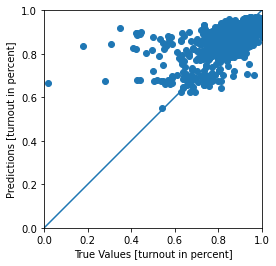

In [223]:
# test_predictions_dnn = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions_DNN)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## 2.3 RF

In [217]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std

In [219]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(train_ps_data, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [225]:
# Use the forest's predict method on the test data
predictions_rf = rf.predict(test_ps_data)# Calculate the absolute errors


In [227]:
errors = abs(predictions_rf - test_labels)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4))

Mean Absolute Error: 0.0395


plot predictions

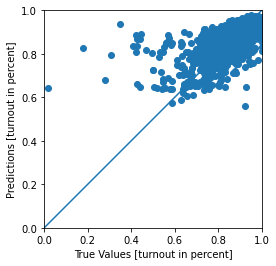

In [228]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions_rf)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## 2.4 Late Fusion

## Images Strand


In [279]:
# Deep Model

inputs_img = keras.Input(shape=(96,96,7))
# Conv Block 1
x = Conv2D(64, kernel_size=(3,3),padding='same', activation='relu')(inputs_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x) 
# Conv Block 2
x = Conv2D(128, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# x = Conv2D(128, kernel_size=(3,3),padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# Conv Block 3
x = Conv2D(256, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# Conv Block 4
x = Conv2D(256, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# Conv Block 5
x = Conv2D(512, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# Flatten and dense
x = Flatten()(x)
# x = Dense(16)(x)
# x = Activation("relu")(x)
# x = BatchNormalization(axis=-1)(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)



## Data Strand


In [280]:
inputs_ps_dat = keras.Input(shape=(56,))
y = Dense(64, activation="relu")(inputs_ps_dat)
y = Dense(64, activation="relu")(y)
y = Dense(32, activation="linear")(y)


## Join the Strands 


In [281]:
combined_input = concatenate([x, y])

In [282]:
z = Dense(128, activation="relu")(combined_input)
z = Dropout(0.4)(z)
z = Dense(32, activation="relu")(combined_input)
z = Dense(1, activation="sigmoid")(z)
model = Model(inputs=[inputs_img, inputs_ps_dat], outputs=z)

In [283]:
print(model.summary())
# plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 96, 96, 64)   4096        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 48, 48, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 48, 48, 64)   256         max_pooling2d_10[0][0]           
______________________________________________________________________________________________

# Running


## Compile



In [284]:
# set paths
best_model_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi_input.h5'
log_dir = 'logs/'

In [285]:
# define callbacks
# select best models, but with early stopping
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,
    mode='min', min_delta=0.0001)
# save best model for fit later
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_mae', verbose=1,
    save_best_only=True, mode='min')
# tensorboard callbacks for debugging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [early_stopper, checkpoint, tensorboard_callback]


In [286]:
# from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
opt = Adam()
# opt = RMSprop()
model.compile(loss='mse',
             metrics=['mae'],
             optimizer=opt)

## Train 

In [287]:
history = model.fit(
    x=[train_images, train_ps_data_normalized], y=train_labels,
    validation_split=0.1, callbacks=callbacks_list,
    epochs=100, batch_size=64)

Epoch 1/100
279/279 [==============================] - 284s 1s/step - loss: 0.0228 - mae: 0.0918 - val_loss: 0.0088 - val_mae: 0.0774

Epoch 00001: val_mae improved from inf to 0.07739, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi_input.h5
Epoch 2/100
279/279 [==============================] - 284s 1s/step - loss: 0.0067 - mae: 0.0518 - val_loss: 0.0073 - val_mae: 0.0649

Epoch 00002: val_mae improved from 0.07739 to 0.06492, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi_input.h5
Epoch 3/100
279/279 [==============================] - 285s 1s/step - loss: 0.0054 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0402

Epoch 00003: val_mae improved from 0.06492 to 0.04017, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi

In [295]:
model.load_weights(best_model_path)


In [296]:

model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae'])



In [297]:
# predictions_DNN = dnn_model.predict(test_ps_data_normalized)
predictions_multi_input = model.predict([test_images, normalizer(test_ps_data)]).flatten()

In [298]:
errors = abs(predictions_multi_input - test_labels)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6))

Mean Absolute Error: 0.038669


In [299]:
# test_results['dnn_model_polling_station_level'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
model.evaluate([test_images, normalizer(test_ps_data)], test_labels, verbose=0)


[0.0042108697816729546, 0.038669437170028687]

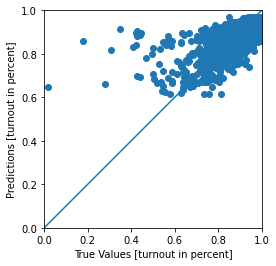

In [300]:
# test_predictions_dnn = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions_multi_input)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


# 3 Compare the three

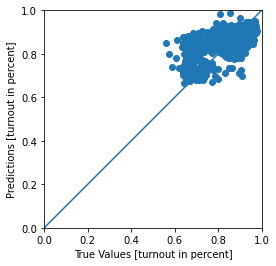

In [239]:
a = plt.axes(aspect='equal')
plt.scatter(predictions_rf, predictions_images)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [242]:
errors = abs(predictions_rf - predictions_images)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6))

Mean Absolute Error: 0.04003


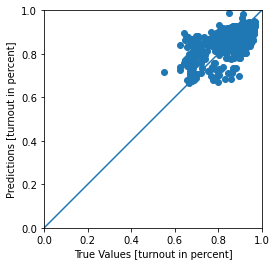

In [240]:
a = plt.axes(aspect='equal')
plt.scatter(predictions_DNN, predictions_images)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [243]:
errors = abs(predictions_DNN - predictions_images)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6))

Mean Absolute Error: 0.036914


In [244]:
errors = abs(predictions_DNN - predictions_rf)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6))

Mean Absolute Error: 0.017256


### Construct Data Frame and correlation matrix

In [245]:
import pandas as pd

In [251]:
predictions_rf.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [301]:
dat_prediction = np.array([test_labels, predictions_images, predictions_DNN, predictions_rf, predictions_multi_input])

In [302]:
dat_prediction.shape

(5, 2200)

In [309]:
dat_prediction = pd.DataFrame(np.array([test_labels, predictions_images, predictions_DNN, predictions_multi_input, predictions_rf])).transpose()

In [310]:
dat_prediction.columns = ['real_test_data', 'preds_sat_images', 'preds_DNN_micro', 'preds_multi_input', 'preds_RF_micro']

In [311]:
type(dat_prediction)

pandas.core.frame.DataFrame

In [312]:
dat_prediction.corr()

,real_test_data,preds_sat_images,preds_DNN_micro,preds_multi_input,preds_RF_micro
real_test_data,1.000000,0.438977,0.670978,0.675012,0.663740
preds_sat_images,0.438977,1.000000,0.587092,0.598317,0.548267
preds_DNN_micro,0.670978,0.587092,1.000000,0.965288,0.911582
preds_multi_input,0.675012,0.598317,0.965288,1.000000,0.918234
preds_RF_micro,0.663740,0.548267,0.911582,0.918234,1.000000


In [313]:
dat_prediction.to_csv('test_data.csv')